### Required Modules

In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
import pickle

In [2]:
# The inputs to the Neural Network
with h5.File('../qlk_jetexp_nn_training_database_minimal.h5', "r") as f:
        inputs = f['input']['block0_values'][()]
        input_names = f['input']['block0_items'][()]
        index_inp = f['input']['axis1'][()]   #row number from 0 to len(inputs)
        
        # The target outputs for the NN
        outputs = f['output']['block0_values'][()]
        output_names = f['output']['block0_items'][()]
        index_out = f['output']['axis1'][()]   #row number from 0 to len(inputs) with some missing rows
        

In [4]:
#Load the data into the dataframe
df_in = pd.DataFrame(inputs,index_inp,input_names)
df_out = pd.DataFrame(outputs,index_out, output_names)

### Load Data 

In [15]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/train_data.pkl")

X_train, Y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/validation_data.pkl")

X_val, Y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [17]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_val = scaler.transform (X_val)


### Neural Network Classifier

In [18]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [19]:
model = nn_classifier()

2022-01-13 17:46:59.704880: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-13 17:46:59.809943: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-13 17:46:59.878761: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = 'acc')

In [27]:
history = model.fit(x_train, Y_train, validation_data = (x_val, Y_val), batch_size = 4096, epochs =25)

Epoch 1/25
6523/6523 [==============================] - 36s 5ms/step - loss: 0.4857 - acc: 0.7462 - val_loss: 0.3928 - val_acc: 0.8099
Epoch 2/25
6523/6523 [==============================] - 28s 4ms/step - loss: 0.3876 - acc: 0.8125 - val_loss: 0.3779 - val_acc: 0.8174
Epoch 3/25
6523/6523 [==============================] - 28s 4ms/step - loss: 0.3763 - acc: 0.8183 - val_loss: 0.3732 - val_acc: 0.8203
Epoch 4/25
6523/6523 [==============================] - 27s 4ms/step - loss: 0.3722 - acc: 0.8206 - val_loss: 0.3698 - val_acc: 0.8223
Epoch 5/25
6523/6523 [==============================] - 28s 4ms/step - loss: 0.3693 - acc: 0.8222 - val_loss: 0.3677 - val_acc: 0.8232
Epoch 6/25
6523/6523 [==============================] - 30s 5ms/step - loss: 0.3674 - acc: 0.8232 - val_loss: 0.3668 - val_acc: 0.8240
Epoch 7/25
6523/6523 [==============================] - 28s 4ms/step - loss: 0.3664 - acc: 0.8241 - val_loss: 0.3662 - val_acc: 0.8244
Epoch 8/25
6523/6523 [==============================] -

In [29]:
import matplotlib.pyplot as plt

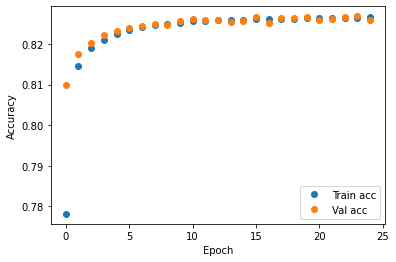

In [35]:
plt.figure()
plt.plot(history.history['acc'], 'o', label = 'Train acc')
plt.plot(history.history['val_acc'], 'o', label = 'Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

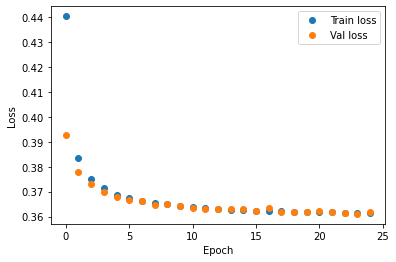

In [36]:
plt.figure()
plt.plot(history.history['loss'], 'o', label = 'Train loss')
plt.plot(history.history['val_loss'], 'o', label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Evaluate Model on Test Set

In [38]:
from sklearn.metrics import roc_curve

In [39]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/test_data.pkl")

X_test, Y_test = test_data.iloc[:,:-1].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [40]:
x_test = scaler.transform (X_test)

In [41]:
predictions = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(Y_test, predictions)

Text(0, 0.5, 'Flase Negative Rate')

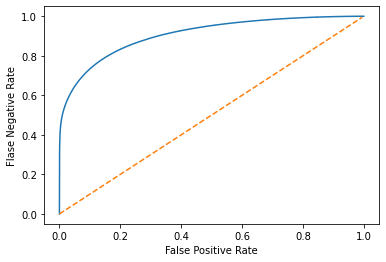

In [46]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')

#### Differences between Thandi and Jackson Classifiers
- Architecture: 20,20,1 vs 30,10,1 
- Data: Full training data set vs first 10,000 
- Scaling: Using standard scaler vs no scaling

### Distributions from classifier

In [72]:
val_preds = model.predict(x_val)
preds = np.round(val_preds).flatten()

In [74]:
no_output = x_val[np.where(preds == 0)]
yes_output = x_val[np.where(preds == 1)] 
assert no_output.shape[0] + yes_output.shape[0] == x_test.shape[0]

In [77]:
columns = list(train_data.iloc[:,:-1].columns)
print(columns)

[b'Ane', b'Ate', b'Autor', b'Machtor', b'x', b'Zeff', b'gammaE', b'q', b'smag', b'alpha', b'Ani1', b'Ati0', b'normni1', b'Ti_Te0', b'logNustar']


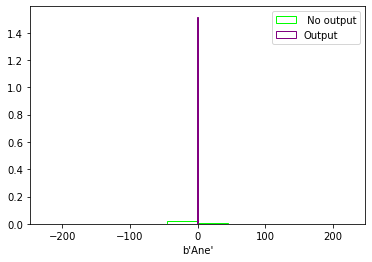

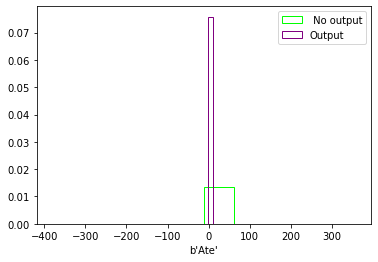

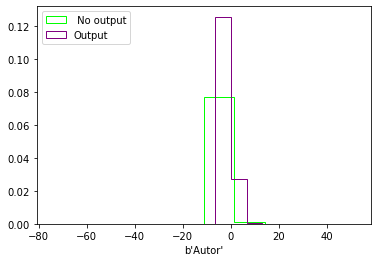

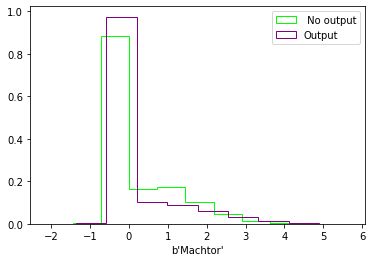

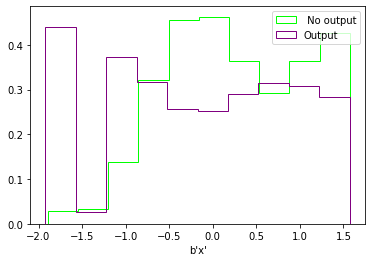

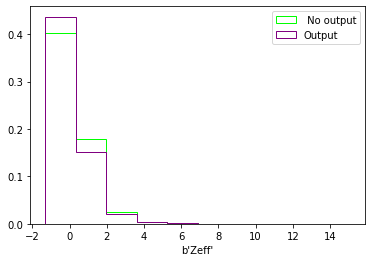

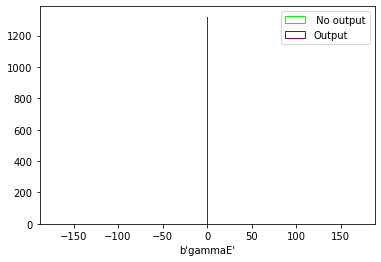

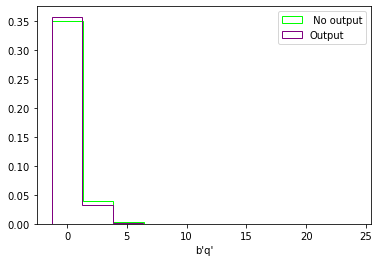

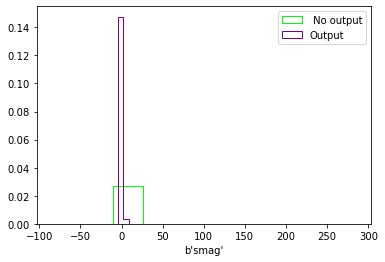

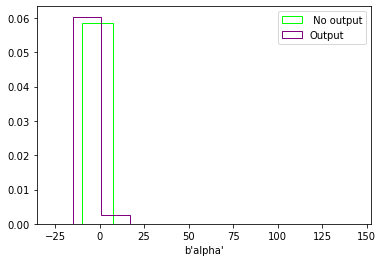

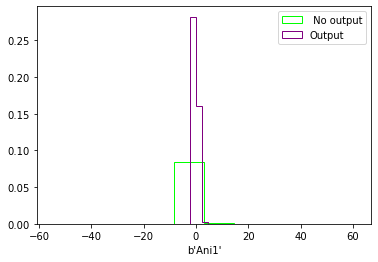

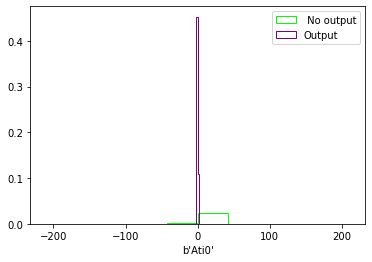

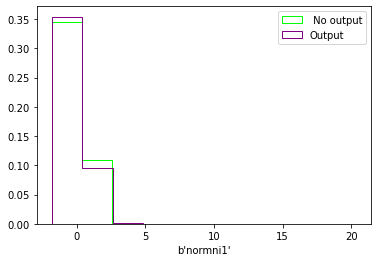

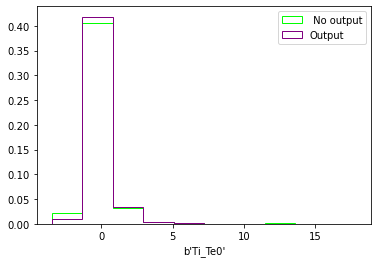

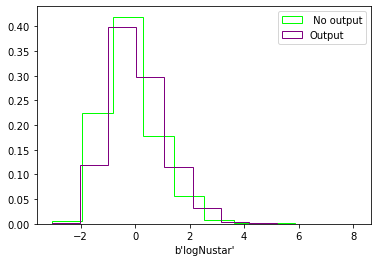

In [81]:
for i, column in enumerate(columns):
    plt.figure()
    plt.hist(no_output[:,i], histtype = 'step', color = 'lime', label =" No output", density = True);
    plt.hist(yes_output[:,i], histtype = 'step', color = 'purple', label = "Output", density = True);
    plt.legend()
    plt.xlabel(column)

### Distributions without scaling

In [82]:
n_output = X_val[np.where(preds == 0)]
y_output = X_val[np.where(preds == 1)] 
assert n_output.shape[0] + y_output.shape[0] == x_test.shape[0]

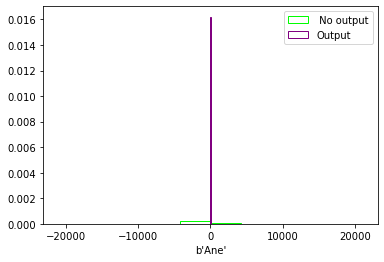

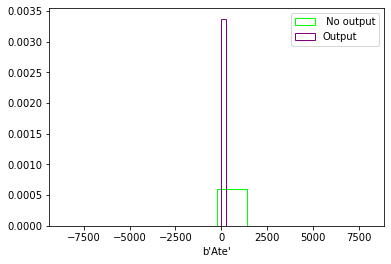

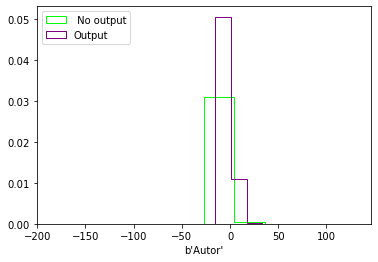

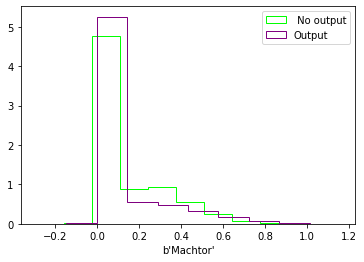

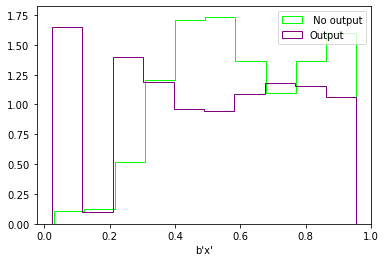

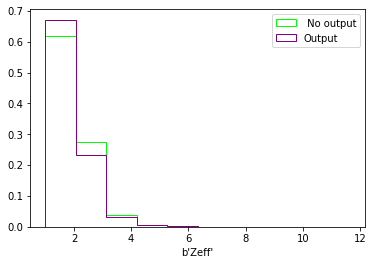

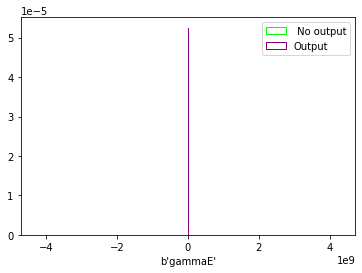

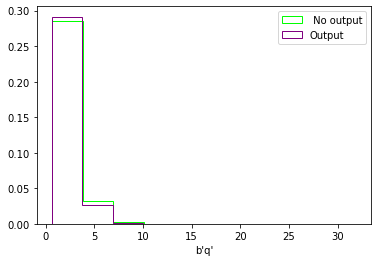

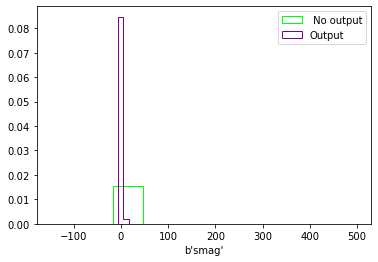

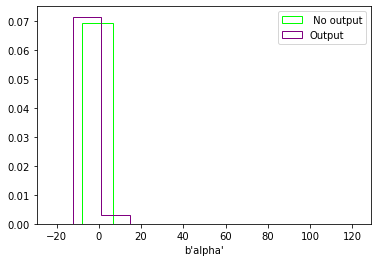

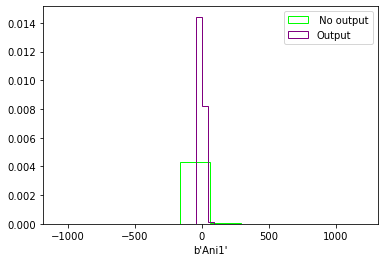

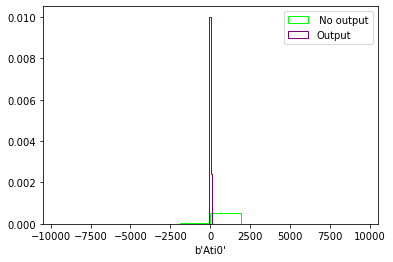

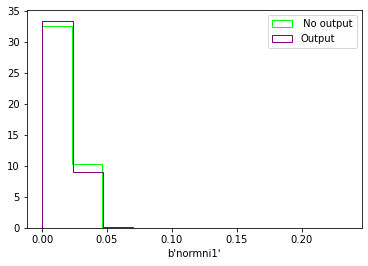

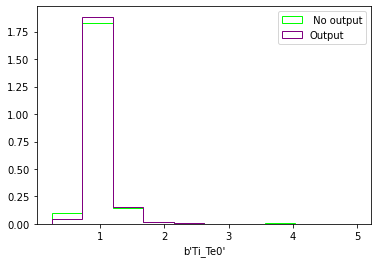

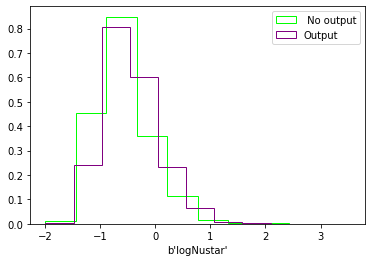

In [83]:
for i, column in enumerate(columns):
    plt.figure()
    plt.hist(n_output[:,i], histtype = 'step', color = 'lime', label =" No output", density = True);
    plt.hist(y_output[:,i], histtype = 'step', color = 'purple', label = "Output", density = True);
    plt.legend()
    plt.xlabel(column)